# Métodos Wrapper y Embedded

En este notebook se revisarán los conceptos de:

1. Métodos *wrapper*
2. Métodos *embedded*

Primero cargamos librerías y funciones necesarias


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

# 1. Métodos Wrapper

Estos métodos utilizan un algoritmo de machine learning como caja negra para rankear distintos subconjuntos de variables de acuerdo a su capacidad predictiva. Normalmente se usan en mediante procedimientos hacia delante/detrás en combinación con validación cruzada.

### *The wrong and right way to do cross-validation*

Este ejemplo ha sido inspirado en *7.10.2 The Wrong and Right Way to Do Cross-validation* del libro
"The Elements of Statistical Learning". Hastie, Tibshirani, Friedman

Error rate (%): 3.5719999999999974


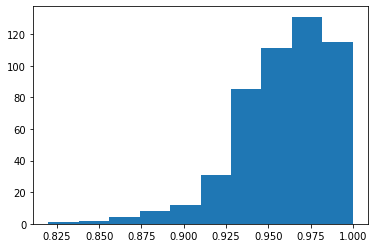

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif


# This is the WRONG way

np.random.seed(0)
score = []

for i in range(500): # This is run for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors are random variables!!
    
    # Note here, the ranking and selection is performed outside the CV loop
    f_test, _ = f_classif(X, y)
    f_test /= np.max(f_test)
    
    
    ranking = np.argsort(f_test)[::-1] 
    selected = ranking[0:50]
    Xs = X[:,selected]
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(Xs):
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

Error rate (%): 52.664


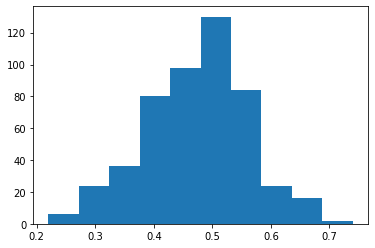

In [3]:
# This is the RIGHT way

np.random.seed(0)
score = []

for i in range(500): # This runs for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors, again random variables
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(X):
        
        # Note here, the ranking and selection is performed inside the CV loop
        f_test, _ = f_classif(X[train,:], y[train])
        f_test /= np.max(f_test)
        ranking = np.argsort(f_test)[::-1] 
        selected = ranking[0:50]
        
        Xs = X[:,selected]
        
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

# 2. Métodos embedded

Vamos a trabajar directamente sobre la base de datos  de viviendas [House Sales in King COunty, USA](https://www.kaggle.com/harlfoxem/housesalesprediction), así que lo primero es cargar los datos

In [4]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = 2015 - house_data['yr_built']
#house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
#house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
#house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
#house_data['lat_plus_long']    = house_data['lat']*house_data['long']

house_data.head()

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,sqm_above,sqm_basement,yr_built,yr_renovated,zip_code,lat,long,sqm_living15,sqm_lot15,years
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,109.625587,0.000000,1955,0,98178,47.5112,-122.257,124.490074,524.902176,60
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,201.599597,37.161216,1951,1991,98125,47.7210,-122.319,157.006138,709.686323,64
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,71.535341,0.000000,1933,0,98028,47.7379,-122.233,252.696269,748.984308,82
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,97.548192,84.541766,1965,0,98136,47.5208,-122.393,126.348134,464.515200,50
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,156.077107,0.000000,1987,0,98074,47.6168,-122.045,167.225472,697.051509,28


In [5]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# Dividimos los datos en entrenamiento y test (75 training, 25 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Normalizamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

Datos entrenamiento:  (16209, 19)
Datos test:  (5404, 19)


In [7]:
feature_names

Index(['bedrooms', 'bathrooms', 'sqm_living', 'sqm_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqm_above', 'sqm_basement',
       'yr_built', 'yr_renovated', 'zip_code', 'lat', 'long', 'sqm_living15',
       'sqm_lot15', 'years'],
      dtype='object')

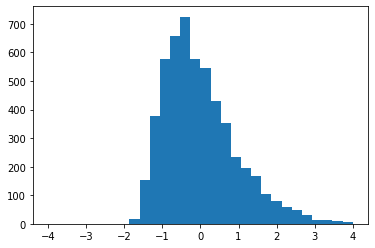

In [8]:
plt.hist(XtestScaled[:,2], range=[-4,4], bins=30)
plt.show()

En este caso, utilizamos la capacidad de Lasso para seleccionar variable

best mean cross-validation score: -39791536451.790
best parameters: {'alpha': 88.58667904100822}


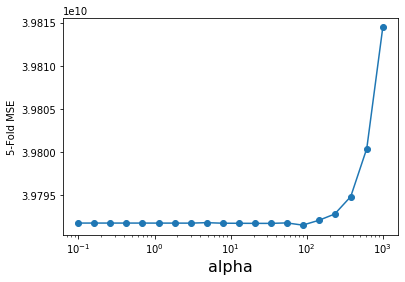

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1,3,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']*100
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)


MSE Modelo Lasso (train): 4.09e+10
MSE Modelo Lasso (test) : 4.55e+10
RMSE Modelo Lasso (train): 2.02e+05
RMSE Modelo Lasso (test) : 2.13e+05
bedrooms -7286.568037323683
bathrooms 12971.426340968575
sqm_living 138729.98392011476
sqm_lot -0.0
floors 0.0
waterfront 40905.92137217891
view 38008.112003379814
condition 11370.134093880128
grade 115992.16335176777
sqm_above 5721.600407571111
sqm_basement 0.0
yr_built -55116.85897600161
yr_renovated 4906.162853933214
zip_code -6117.984894838216
lat 74512.03321697678
long -10616.154550132227
sqm_living15 10722.139804867671
sqm_lot15 -0.0
years 2594.9969748270273


In [11]:
house_data.describe()

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,sqm_above,sqm_basement,yr_built,yr_renovated,zip_code,lat,long,sqm_living15,sqm_lot15,years
count,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,193.229008,1403.483212,1.494309,0.007542,0.234303,3.409430,7.656873,166.146932,27.082077,1971.005136,84.402258,98077.939805,47.560053,-122.213896,184.556766,1186.228346,43.994864
std,3.671272e+05,0.930062,0.770163,85.325951,3848.091438,0.539989,0.086517,0.766318,0.650743,1.175459,76.932169,41.116567,29.373411,401.679240,53.505026,0.138564,0.140828,63.674936,2536.641292,29.373411
min,7.500000e+04,0.000000,0.000000,26.941882,48.309581,1.000000,0.000000,0.000000,1.000000,1.000000,26.941882,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,37.068313,60.479879,0.000000
25%,3.219500e+05,3.000000,1.750000,132.572638,468.231322,1.000000,0.000000,0.000000,3.000000,7.000000,110.554618,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,138.425530,473.805504,18.000000
50%,4.500000e+05,3.000000,2.250000,177.444806,707.735359,1.500000,0.000000,0.000000,3.000000,7.000000,144.928742,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,170.941594,707.921165,40.000000
75%,6.450000e+05,4.000000,2.500000,236.902752,992.947692,2.000000,0.000000,0.000000,4.000000,8.000000,205.315718,52.025702,1997.000000,0.000000,98118.000000,47.678000,-122.125000,219.251174,936.741352,64.000000
max,7.700000e+06,33.000000,8.000000,1257.907162,153416.271231,3.500000,1.000000,4.000000,5.000000,13.000000,874.217606,447.792653,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,576.927878,80937.128448,115.000000


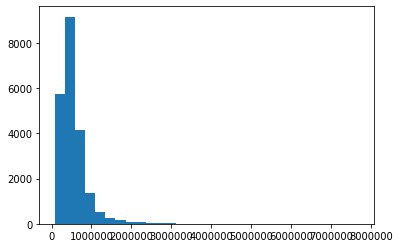

In [12]:
plt.hist(house_data.price, bins=30)
plt.show()

# Vemos cómo está muy escorada hacia la izquierda

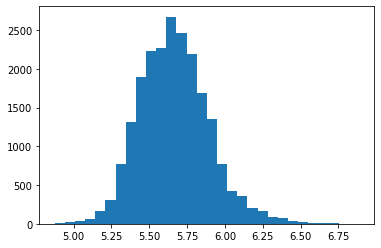

In [13]:
plt.hist(np.log10(house_data.price), bins=30)
plt.show()

# Mientras que si le aplicamos una transformación logarítimica, se queda mucho más centrada.
# Esto es parte del conocimiento del problema, y es conveniente que le metáis todo el posible.

# Si estáis investigando entonces normalmente no podéis hacer esto, porque sería "trampa" : )

In [14]:
# Repetimos todo con una normalización logarítmica
data = house_data.values

y = np.log10(data[:,0:1])     # nos quedamos con la 1ª columna, price (EN FORMATO LOGARÍTMICO)
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Normalizamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

Datos entrenamiento:  (16209, 19)
Datos test:  (5404, 19)


best mean cross-validation score: -0.012
best parameters: {'alpha': 2.94705170255181e-05}


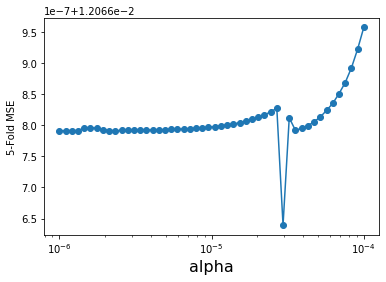

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-6,-4,50) # probad a variar estos valores para ver cómo cambia la gráfica de alpha
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']*10
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

RMSE Modelo Lasso (train): 0.11
RMSE Modelo Lasso (test) : 0.109
bedrooms -0.003910942186796802
bathrooms 0.02265629026851341
sqm_living 0.054260744045531197
sqm_lot 0.006651249303133973
floors 0.017007297001634232
waterfront 0.013983444639178883
view 0.018830688349832068
condition 0.01797765104322894
grade 0.0807781520359126
sqm_above 0.0
sqm_basement 0.002837157471642987
yr_built -0.041873847958833435
yr_renovated 0.00656850393219244
zip_code -0.014414470616315796
lat 0.08402728487938117
long -0.010258016471059573
sqm_living15 0.02949755453555452
sqm_lot15 -0.0018245988895744054
years 0.00033232346714476084


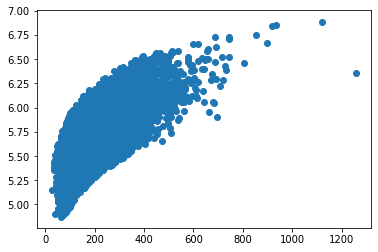

In [18]:
plt.scatter(house_data["sqm_living"], np.log10(house_data["price"]))
plt.show()

# vemos como la transformada está más compactada que la original (suele ser bueno)

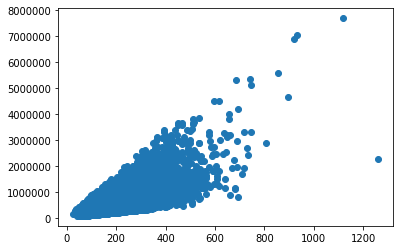

In [19]:
plt.scatter(house_data["sqm_living"], house_data["price"])
plt.show()

Como puede apreciarse, con este algoritmo hemos conseguido "desactivar" algunas variables (*sqm_lot*, *sqm_basement*, *long*, *bedrooms_squared*, *bed_bath_rooms*), lo que mejora la interpretabilidad del modelo a costa de aumentar ligeramente el error en test con respecto al método Ridge.

No obstante, siguen apareciendo algunas incoherencias con respecto al valor de los coeficientes, como por ejemplo el asociado a la variable *bedrooms* que tiene valor negativo. 

Vamos a aumentar el parámetro de regularización y observar los resultados obtenidos:

Hemos aumentado el error, pero a cambio:

1. Tenemos un modelo más sencillo (menos variables al haber muchos coeficientes nulos) y por tanto, menos susceptible a sufrir overfitting
2. Mejoramos la interpretabilidad del modelo, las variables supervivientes (con coeficiente distintos de cero) parecen concordar con nuestra intuición sobre problema a resolver

Y una vez llegados a este punto, ¿qué podemos hacer? El error de entrenamiento/validación y test es similar, pero todavía es muy alto, así que: 

1. Se podrían definir nuevas variables que nos ayuden a mejorar el error de predicción (mse)
2. Jugar con el parámetro de regularización, para mantener el compromiso entre sencillez/interpretabilidad del modelo y error de predicción (MSE).

